In [125]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing


In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data loading**

Load the dataset from Google Drive and briefly inspect it

In [127]:
data = pd.read_csv("/content/drive/MyDrive/marketing_data.csv")

In [128]:
data.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP
5,7348,1958,PhD,Single,"$71,691.00",0,0,3/17/14,0,336,130,411,240,32,43,1,4,7,5,2,0,0,0,0,0,1,0,SP
6,4073,1954,2n Cycle,Married,"$63,564.00",0,0,1/29/14,0,769,80,252,15,34,65,1,10,10,7,6,1,0,0,0,0,1,0,GER
7,1991,1967,Graduation,Together,"$44,931.00",0,1,1/18/14,0,78,0,11,0,0,7,1,2,1,3,5,0,0,0,0,0,0,0,SP
8,4047,1954,PhD,Married,"$65,324.00",0,1,1/11/14,0,384,0,102,21,32,5,3,6,2,9,4,0,0,0,0,0,0,0,US
9,9477,1954,PhD,Married,"$65,324.00",0,1,1/11/14,0,384,0,102,21,32,5,3,6,2,9,4,0,0,0,0,0,0,0,IND


In [129]:
data.dtypes

ID                      int64
Year_Birth              int64
Education              object
Marital_Status         object
 Income                object
Kidhome                 int64
Teenhome                int64
Dt_Customer            object
Recency                 int64
MntWines                int64
MntFruits               int64
MntMeatProducts         int64
MntFishProducts         int64
MntSweetProducts        int64
MntGoldProds            int64
NumDealsPurchases       int64
NumWebPurchases         int64
NumCatalogPurchases     int64
NumStorePurchases       int64
NumWebVisitsMonth       int64
AcceptedCmp3            int64
AcceptedCmp4            int64
AcceptedCmp5            int64
AcceptedCmp1            int64
AcceptedCmp2            int64
Response                int64
Complain                int64
Country                object
dtype: object

Adjust data types and fix typo in ' Income '

In [130]:
data = data.astype({
    'AcceptedCmp1':'bool', 
    'AcceptedCmp2':'bool', 
    'AcceptedCmp3':'bool', 
    'AcceptedCmp4':'bool', 
    'AcceptedCmp5':'bool', 
    'Response': 'bool', 
    'Complain': 'bool',
    })
data.Dt_Customer = pd.to_datetime(data.Dt_Customer)
data = data.rename(columns={' Income ': 'Income'})

In [131]:
data.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518
std,3246.662198,11.984069,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645
min,0.000000,1893.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,1959.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,5458.500000,1970.000000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,8427.750000,1977.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000
max,11191.000000,1996.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000


# **Detecting NA's**

In [132]:
data.isna().sum()[data.isna().sum() != 0] # Show columns that have NA's and the amount of them

Income    24
dtype: int64

In [133]:
data[data.Income.isna()] # Check out observations with Income == NaN

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
134,8996,1957,PhD,Married,NaN,2,1,2012-11-19,4,230,42,192,49,37,53,12,7,2,8,9,False,False,False,False,False,False,False,GER
262,1994,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5,5,6,0,2,1,1,1,0,2,7,False,False,False,False,False,False,False,US
394,3769,1972,PhD,Together,NaN,1,0,2014-03-02,17,25,1,13,0,0,3,1,1,0,3,7,False,False,False,False,False,False,False,AUS
449,5255,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,1,3,3,263,362,0,27,0,0,1,False,False,False,False,False,False,False,AUS
525,8268,1961,PhD,Married,NaN,0,1,2013-07-11,23,352,0,27,10,0,15,3,6,1,7,6,False,False,False,False,False,False,False,CA
590,10629,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25,3,43,17,4,17,3,3,0,3,8,False,False,False,False,False,False,False,GER
899,10475,1970,Master,Together,NaN,0,1,2013-04-01,39,187,5,65,26,20,14,2,4,2,6,5,False,False,False,False,False,False,False,US
997,9235,1957,Graduation,Single,NaN,1,1,2014-05-27,45,7,0,8,2,0,1,1,1,0,2,7,False,False,False,False,False,False,False,GER
1096,4345,1964,2n Cycle,Single,NaN,1,1,2014-01-12,49,5,1,9,2,0,4,1,1,0,2,7,False,False,False,False,False,False,False,AUS
1185,7187,1969,Master,Together,NaN,1,1,2013-05-18,52,375,42,48,94,66,96,7,4,10,4,3,False,False,False,False,False,False,False,AUS


Formatting of the column Income is needed to have it converted to float so that it can be further utilised in the analysis

In [134]:
data['Clean_Income'] = data.Income.apply(lambda x: re.sub(r'[^\d.]', '', str(x)) if pd.notna(x) else np.nan )

In [135]:
data.Clean_Income = data.Clean_Income.astype('float64')

There are 24 NA's in our dataset. It is possible to replace the NA's with averages incomes of some categorical variable. Lets see some categorical columns to choose on what to base our averages.

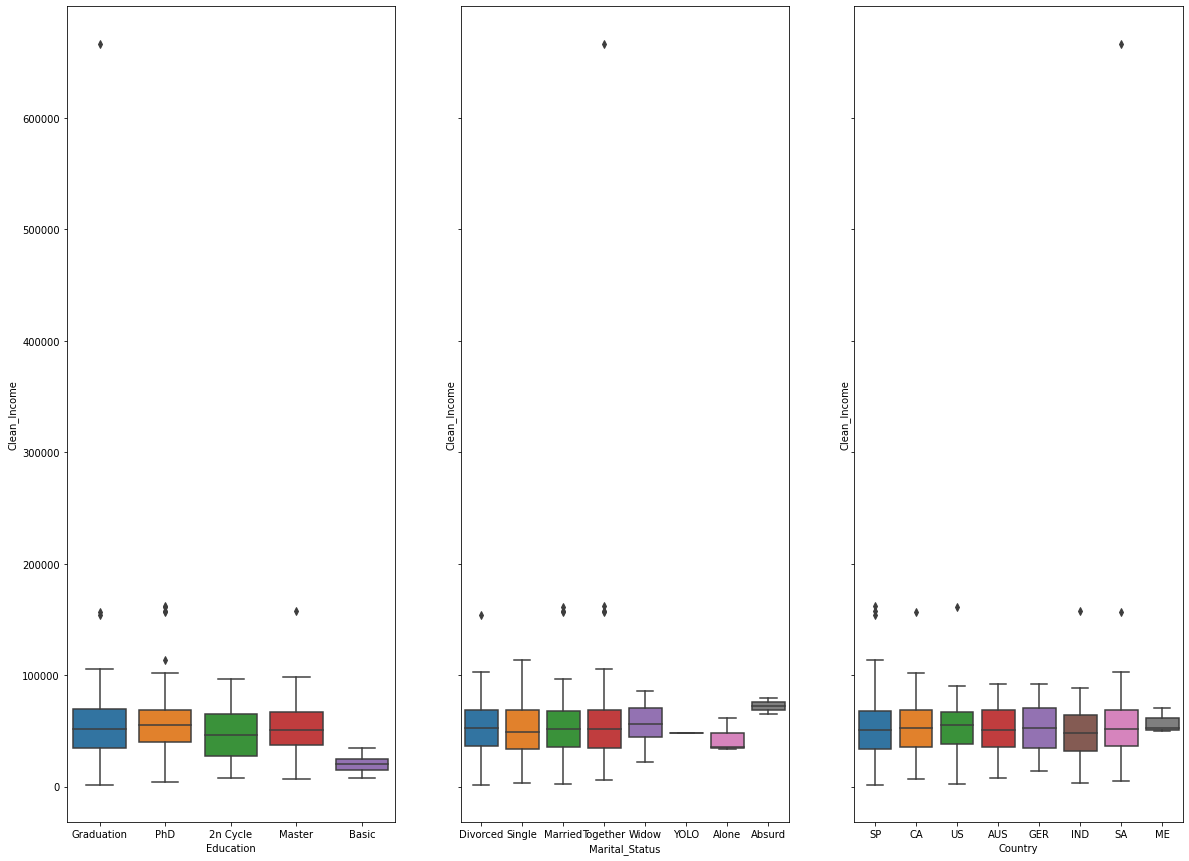

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(20, 15)
sns.boxplot(x = data.Education, y = data.Clean_Income, ax=ax1)
sns.boxplot(x = data.Marital_Status, y = data.Clean_Income, ax=ax2)
sns.boxplot(x = data.Country, y = data.Clean_Income, ax=ax3)

plt.show()

It looks like (and also quite logical) Clean_Income is best represented with Education. Let's replace the NA's in income with the averages of those persons' education levels.

In [137]:
education_means = data.groupby('Education')['Clean_Income'].mean()

In [138]:
for cat in data.Education.unique().tolist():
  indexes = data[data.Clean_Income.isna() & (data.Education == cat)].Clean_Income.index
  data.iloc[indexes, -1] = education_means[cat]


In [139]:
data['Clean_Income'].isna().sum()

0

# **Outlier detection**

Function `detect_outliers(values)` uses Z-score (points with Z-score > 5 are considered outliers; althought in traditional statistics values about > 3 are considered outliers, in data mining usually higher score values are considered) to detect outliers in integer and float variables

In [140]:
def detect_outliers(values: pd.Series):
  threshhold = 5

  z_scores = stats.zscore(values)
  outliers = values[np.abs(z_scores) > threshhold]

  return {"id": outliers.index, "value": outliers.values}

In [141]:
for column in data.select_dtypes(include=[np.number]):
  print(f"{column}: { (detect_outliers(data[column]))['value'].tolist() }")


ID: []
Year_Birth: [1893, 1899, 1900]
Kidhome: []
Teenhome: []
Recency: []
MntWines: []
MntFruits: []
MntMeatProducts: [1725, 1622, 1725, 1607, 1582]
MntFishProducts: []
MntSweetProducts: [262, 263]
MntGoldProds: [321, 362]
NumDealsPurchases: [12, 12, 12, 12, 15, 15, 15, 15, 15, 13, 13, 15, 13, 15]
NumWebPurchases: [25, 27, 27, 23]
NumCatalogPurchases: [28, 28, 28, 22]
NumStorePurchases: []
NumWebVisitsMonth: [19, 19, 20, 20, 20]
Clean_Income: [666666.0]


Let's check out some variables that have outliers!

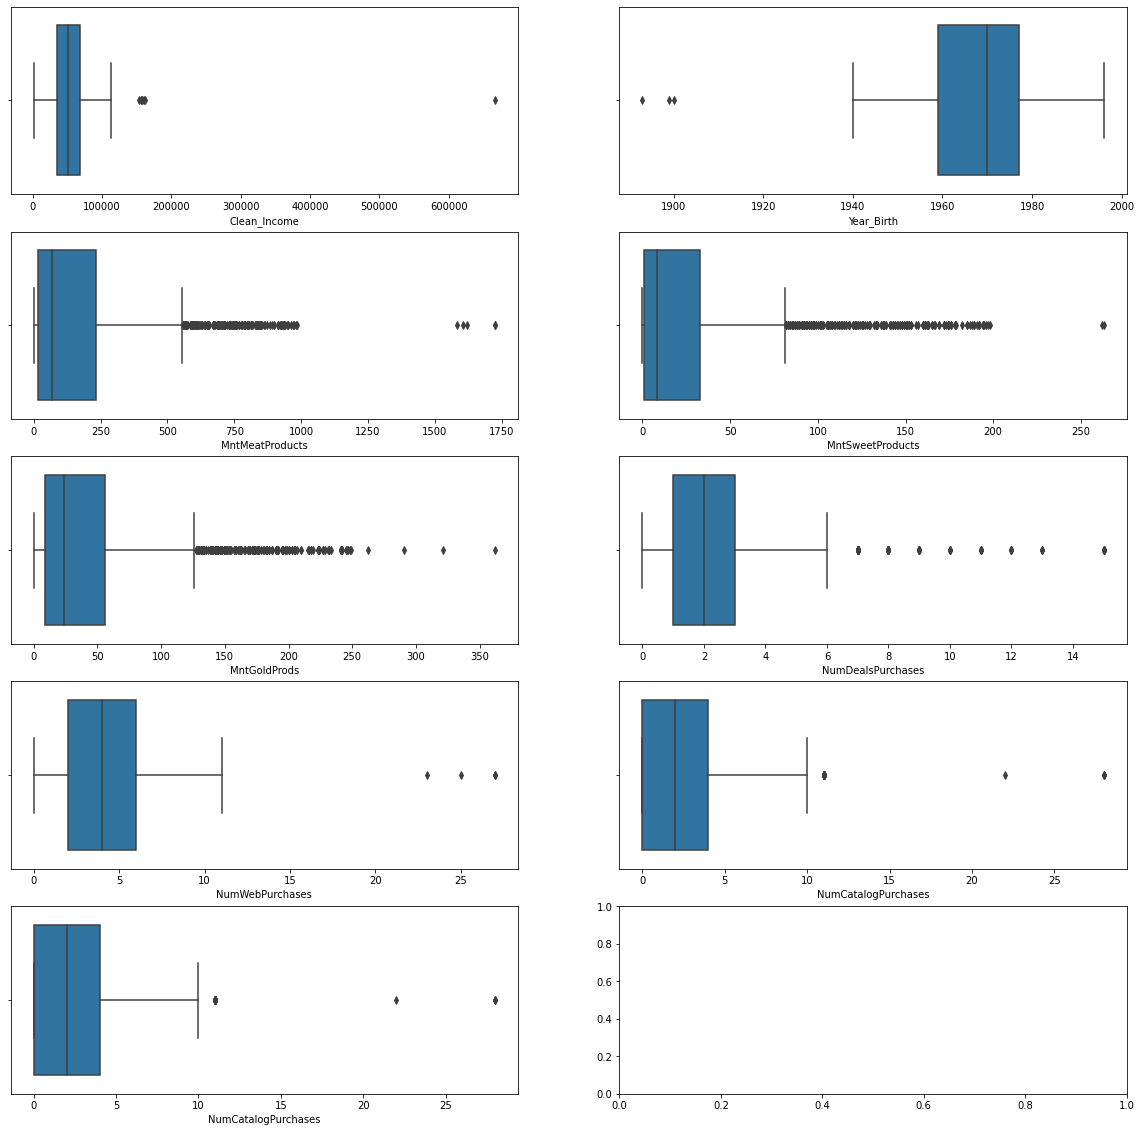

In [142]:
fig, (ax) = plt.subplots(5,2) 

fig.set_size_inches(20, 20)
sns.boxplot(x=data.Clean_Income, ax=ax[0, 0])
sns.boxplot(x=data.Year_Birth, ax=ax[0, 1])
sns.boxplot(x=data.MntMeatProducts, ax=ax[1,0])
sns.boxplot(x=data.MntSweetProducts, ax=ax[1,1])
sns.boxplot(x=data.MntGoldProds, ax=ax[2,0])
sns.boxplot(x=data.NumDealsPurchases, ax=ax[2,1])
sns.boxplot(x=data.NumWebPurchases, ax=ax[3,0])
sns.boxplot(x=data.NumCatalogPurchases, ax=ax[3,1])
sns.boxplot(x=data.NumCatalogPurchases, ax=ax[4,0])


plt.show()

In [143]:
outliers_to_drop = []
for column in data.select_dtypes(include=[np.number]):
  outliers_to_drop.extend(detect_outliers(data[column])['id'])

print(f"{ round((len(set(outliers_to_drop))/len(data.index))*100, 2) }% of observations are outliers.")

1.16% of observations are outliers.


Based on the Z-score and plots, there are only about 1% of outliers, so it would be reasonable to delete all the anomalies that `detect_outliers(values)` gave us.


In [144]:
no_outliers_data = data.drop(outliers_to_drop, axis=0)

# **Data transformations**

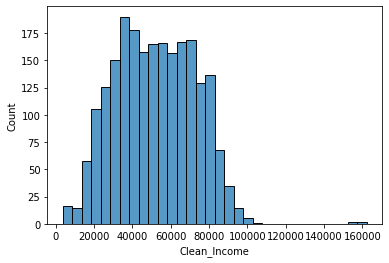

In [145]:
sns.histplot(no_outliers_data.Clean_Income)

As can be seen from the histogram, there are still some extreme values in income. To fix that, we will max the income at 100000.

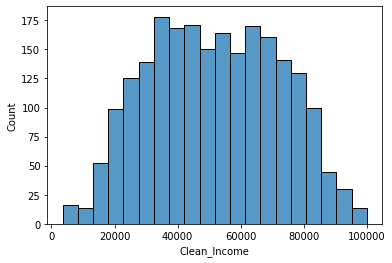

In [146]:
clipped_income = no_outliers_data.Clean_Income.apply(lambda x: 100000 if x > 100000 else x)
income_hist = sns.histplot(clipped_income)

Skew: 1.1715465584578548


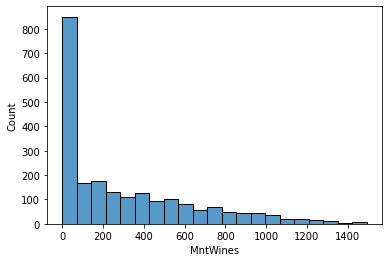

In [147]:
wines = sns.histplot(no_outliers_data.MntWines)
print(f"Skew: {no_outliers_data.MntWines.skew()}")

Although some variables like MntWines, MntFruits and etc. are positively skewed, our sample size is big enough, so it wouldn't affect our performance. All the other main variables look quite good. We may further transform the data in the future.

# **Feature engineering**

Let's check out the Year_Birth histogram

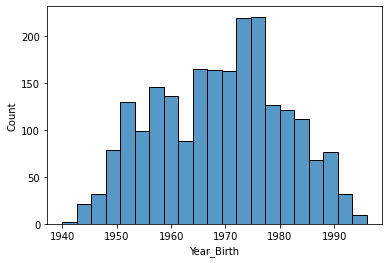

In [148]:
sns.histplot(no_outliers_data.Year_Birth)

It would be effective to discretize the birth years into bins of 5 years. Binned discrete feature would help make our future model more accurate and working with discrete varaibles makes our analysis easier.

In [149]:
print(f'Minimal year of birth in the data set is { no_outliers_data.Year_Birth.min() }, maximal is { no_outliers_data.Year_Birth.max() }.')

Minimal year of birth in the data set is 1940, maximal is 1996.


In [150]:
year_bins = pd.cut(no_outliers_data.Year_Birth, bins = np.arange(1940, 2005, 5).tolist(), 
                  labels=[ f'{x}-{x+5}' for x in np.arange(1940, 2000, 5).tolist() ]) 
#Discretize our variable into bins of 5 years and add labels

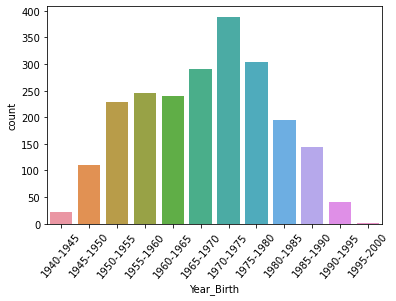

In [151]:
sns.countplot(x = year_bins) \
  .set_xticklabels(years.xaxis.get_ticklabels(), rotation=50)
plt.show()

Looks much better! The distribution has also became closer to Gaussian.

Let's now make some features out of Dt_Customer column. We will make feature for year, month, day and day of the week of Dt_Customer.

In [152]:
data['Dt_Customer_Year'] = data.Dt_Customer.dt.year
data['Dt_Customer_Month'] = data.Dt_Customer.dt.month
data['Dt_Customer_Day'] = data.Dt_Customer.dt.day
data['Dt_Customer_DayOfWeek'] = data.Dt_Customer.dt.dayofweek

Next we'll make features out of our categorical variables!

In [153]:
e = preprocessing.OneHotEncoder().fit_transform(data[['Education', 'Country', 'Marital_Status']])
e.toarray()[5]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0.])

In [154]:
featured_data = pd.get_dummies(no_outliers_data, columns=['Education', 'Marital_Status', 'Country' ])

# **Anomaly detection** (let's check out some joint distributions)

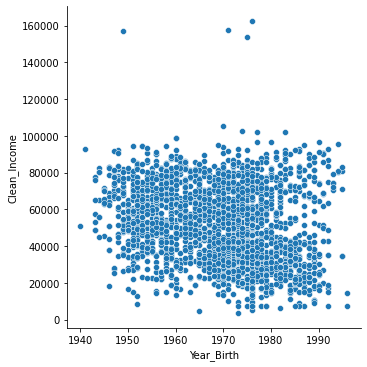

In [155]:
sns.relplot(x = featured_data.Year_Birth, y = featured_data.Clean_Income)

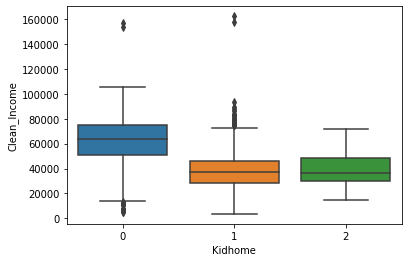

In [156]:
sns.boxplot(x = featured_data.Kidhome, y = featured_data.Clean_Income)

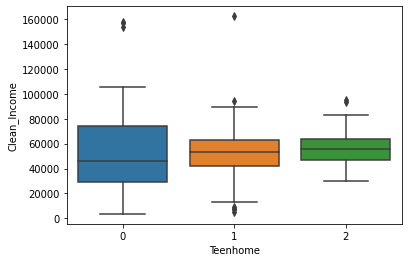

In [157]:
sns.boxplot(x = featured_data.Teenhome, y = featured_data.Clean_Income)

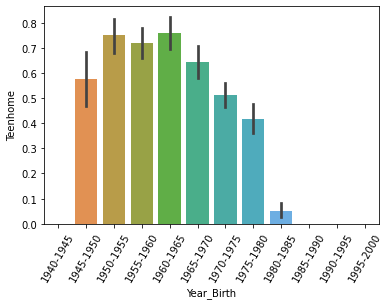

In [158]:
sns.barplot(x = year_bins, y = featured_data.Teenhome, estimator=np.mean) \
  .set_xticklabels(c.xaxis.get_ticklabels(), rotation=60)
plt.show()

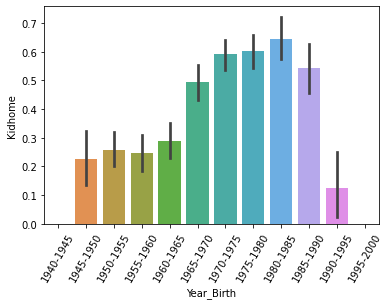

In [159]:
sns.barplot(x = year_bins, y = featured_data.Kidhome, estimator=np.mean) \
  .set_xticklabels(c.xaxis.get_ticklabels(), rotation=60)
plt.show()

Joint distributions of year of birth and amount of kids and teens at home look very logical: older people have less kids and more teens and vice versa for younger customers.